<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# LightGBM: A Highly Efficient Gradient Boosting Decision Tree

This notebook gives an example of how to perform multiple rounds of training and testing of LightGBM models to generate point forecasts of product sales in retail. We will train the LightGBM models based on the Orange Juice dataset.

[LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is an ensemble technique in which models are added to the ensemble sequentially and at each iteration a new model is trained with respect to the error of the whole ensemble learned so far. More detailed information about gradient boosting can be found in this [tutorial paper](https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full). Using this technique, LightGBM achieves great accuracy in many applications. Apart from this, it is designed to be distributed and efficient with the following advantages:
* Fast training speed and high efficiency.
* Low memory usage.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

Due to these advantages, LightGBM has been widely-used in a lot of [winning solutions](https://github.com/microsoft/LightGBM/blob/master/examples/README.md#machine-learning-challenge-winning-solutions) of machine learning competitions.

## Global Settings and Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import math
import datetime
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import scrapbook as sb

from fclib.common.utils import git_repo_path
from fclib.models.lightgbm import predict
from fclib.evaluation.evaluation_utils import MAPE
from fclib.common.plot import plot_predictions_with_history
from fclib.dataset.ojdata import download_ojdata, split_train_test, FIRST_WEEK_START
from fclib.feature_engineering.feature_utils import (
    week_of_month,
    df_from_cartesian_product,
    combine_features,
)

warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
LightGBM version: 2.3.0


## Parameter Settings

In what follows, we define global settings related to the model and feature engineering. LightGBM supports both classification models and regression models. In our case, we set the objective function to `mape` which stands for mean-absolute-percentage-error (MAPE) since we will build a regression model to predict product sales and evaluate the accuracy of the model using MAPE.

Generally, we can adjust the number of leaves (`num_leaves`), the minimum number of data in each leaf (`min_data_in_leaf`), maximum number of boosting rounds (`num_rounds`), the learning rate of trees (`learning_rate`) and `early_stopping_rounds` (to avoid overfitting) in the model to get better performance. Besides, we can also adjust other supported parameters to optimize the results. [In this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst), a list of all the parameters is given. In addition, advice on how to tune these parameters can be found [in this url](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst).

We will use historical weekly sales, date time information, and product information as input features to train the model. Prior sales are used as lag features and `lags` contains the lags where each number indicates the number of time steps (i.e., weeks) that we shift the data backwards to get the historical sales. We also use the average sales within a certain time window in the past as a moving average feature. `window_size` controls the size of the moving window. Apart from these parameters, we use `use_columns` and `categ_fea` to denote all other features that we leverage in the model and the categorical features, respectively.


In [3]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = True

# Data directory
DATA_DIR = os.path.join(git_repo_path(), "ojdata")

# Parameters of LightGBM model
params = {
    "objective": "mape",
    "num_leaves": 124,
    "min_data_in_leaf": 340,
    "learning_rate": 0.1,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.87,
    "bagging_freq": 19,
    "num_rounds": 940,
    "early_stopping_rounds": 125,
    "num_threads": 16,
    "seed": 1,
}

# Lags, window size, and feature column names
lags = np.arange(2, 20)
window_size = 40
used_columns = [
    "store",
    "brand",
    "week",
    "week_of_month",
    "month",
    "deal",
    "feat",
    "move",
    "price",
    "price_ratio",
]
categ_fea = ["store", "brand", "deal"]

# Forecasting settings
N_SPLITS = 10
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 156

## Data Preparation

We need to download the Orange Juice data and split it into training and test sets for multiple forecast rounds. By default, the following cell will download and spit the data. If you've already done so, you may skip this part by switching `DOWNLOAD_SPLIT_DATA` to `False`.

We store the training data and test data using dataframes. In each forecast round, the training data includes a training dataframe and an auxiliary dataframe with the training dataframe containing historical sales up to the time we make forecasts and auxiliary dataframe containing price/promotion information up to the maximum week that we want to forecast. Here we assume that future price and promotion information up to a certain number of weeks ahead is predetermined and known. There is a one-week gap between the current week and the first target week of forecasting as we want to leave time for planning inventory in practice.

In [4]:
if DOWNLOAD_SPLIT_DATA:
    download_ojdata(DATA_DIR)
    split_train_test(
        DATA_DIR,
        n_splits=N_SPLITS,
        horizon=HORIZON,
        gap=GAP,
        first_week=FIRST_WEEK,
        last_week=LAST_WEEK,
        write_csv=True,
    )
    print("Finished data downloading and splitting.")

Data already exists at the specified location.
Finished data downloading and splitting.


## Feature Engineering

Next we create a function to extract a number of features from the data for training the forecasting model. These features include
* datetime features including week, week of the month, and month
* historical weekly sales of each orange juice in recent weeks
* average sales of each orange juice during recent weeks
* other features including `store`, `brand`, `deal`, `feat` columns and price features

Note that the logarithm of the unit sales is stored in a column named `logmove` both for `train_df` and `test_df`. We compute the unit sales `move` based on this quantity.

In [5]:
def create_features(pred_round, train_dir, lags, window_size, used_columns):
    """Create input features for model training and testing.

    
    Args: 
        pred_round (int): Prediction round (1, 2, ...)
        train_dir (str): Path of the training data directory 
        lags (np.array): Numpy array including all the lags
        window_size (int): Maximum step for computing the moving average
        used_columns (list[str]): A list of names of columns used in model training (including target variable)

    Returns:
        pd.Dataframe: Dataframe including all the input features and target variable
        int: Last week of the training data 
    """

    # Load training data
    train_df = pd.read_csv(os.path.join(train_dir, "train_" + str(pred_round) + ".csv"))
    train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
    train_df = train_df[["store", "brand", "week", "move"]]

    # Create a dataframe to hold all necessary data
    store_list = train_df["store"].unique()
    brand_list = train_df["brand"].unique()
    train_end_week = train_df["week"].max()
    week_list = range(FIRST_WEEK, train_end_week + GAP + HORIZON)
    d = {"store": store_list, "brand": brand_list, "week": week_list}
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(train_dir, "auxi_" + str(pred_round) + ".csv"))
    data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])

    # Create relative price feature
    price_cols = [
        "price1",
        "price2",
        "price3",
        "price4",
        "price5",
        "price6",
        "price7",
        "price8",
        "price9",
        "price10",
        "price11",
    ]
    data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
    data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
    data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
    data_filled.drop(price_cols, axis=1, inplace=True)

    # Fill missing values
    data_filled = data_filled.groupby(["store", "brand"]).apply(
        lambda x: x.fillna(method="ffill").fillna(method="bfill")
    )

    # Create datetime features
    data_filled["week_start"] = data_filled["week"].apply(
        lambda x: FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
    )
    data_filled["year"] = data_filled["week_start"].apply(lambda x: x.year)
    data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
    data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
    data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
    data_filled.drop("week_start", axis=1, inplace=True)

    # Create other features (lagged features, moving averages, etc.)
    features = data_filled.groupby(["store", "brand"]).apply(
        lambda x: combine_features(x, ["move"], lags, window_size, used_columns)
    )

    # Drop rows with NaN values
    features.dropna(inplace=True)

    return features, train_end_week

## Model Training

We then perform a multi-round training by fitting a LightGBM model using the training data in each forecast round. After the models are trained, we apply them to generate forecasts for the target weeks. The paradigm of model training and testing is illustrated in the following diagram

<img src="https://user-images.githubusercontent.com/20047467/77784194-84faee00-7030-11ea-83ee-6e2c33eb2434.png">

In [6]:
# Train and predict for all forecast rounds
pred_all = []
metric_all = []
train_dir = os.path.join(DATA_DIR, "train")
for r in range(1, N_SPLITS + 1):
    print("---------- Round " + str(r) + " ----------")
    features, train_end_week = create_features(r, train_dir, lags, window_size, used_columns)
    train_fea = features[features.week <= train_end_week].reset_index(drop=True)
    print("Maximum training week number is {}".format(max(train_fea["week"])))

    # Create training set
    dtrain = lgb.Dataset(train_fea.drop("move", axis=1, inplace=False), label=train_fea["move"])

    # Train GBM model
    print("Training LightGBM model started.")
    bst = lgb.train(params, dtrain, valid_sets=[dtrain], categorical_feature=categ_fea, verbose_eval=False,)
    print("Training LightGBM model finished.")

    # Generate forecasts
    test_fea = features[features.week >= train_end_week + GAP].reset_index(drop=True)
    idx_cols = ["store", "brand", "week"]
    pred = predict(test_fea, bst, target_col="move", idx_cols=idx_cols).sort_values(by=idx_cols).reset_index(drop=True)
    print("Prediction results:")
    print(pred.head())
    print("")

    # Keep the predictions
    pred["round"] = r
    pred_all.append(pred)

pred_all = pd.concat(pred_all, axis=0)
pred_all.rename(columns={"move": "prediction"}, inplace=True)
pred_all = pred_all[["round", "week", "store", "brand", "prediction"]]

---------- Round 1 ----------
Maximum training week number is 135
Training LightGBM model started.
Training LightGBM model finished.
Prediction results:
   store  brand  week   move
0      2      1   137   9151
1      2      1   138  24055
2      2      2   137   4879
3      2      2   138  12035
4      2      3   137   2156

---------- Round 2 ----------
Maximum training week number is 137
Training LightGBM model started.
Training LightGBM model finished.
Prediction results:
   store  brand  week  move
0      2      1   139  9424
1      2      1   140  7544
2      2      2   139  7377
3      2      2   140  6843
4      2      3   139  3288

---------- Round 3 ----------
Maximum training week number is 139
Training LightGBM model started.
Training LightGBM model finished.
Prediction results:
   store  brand  week  move
0      2      1   141  6717
1      2      1   142  8090
2      2      2   141  7881
3      2      2   142  7206
4      2      3   141  2003

---------- Round 4 ---------

## Model Evaluation

To evaluate the model performance, we compute MAPE of the forecasts from all the forecast rounds below.

In [7]:
# Evaluate prediction accuracy
test_all = []
test_dir = os.path.join(DATA_DIR, "test")
for r in range(1, N_SPLITS + 1):
    test_df = pd.read_csv(os.path.join(test_dir, "test_" + str(r) + ".csv"))
    test_all.append(test_df)
test_all = pd.concat(test_all, axis=0).reset_index(drop=True)
test_all["actual"] = test_all["logmove"].apply(lambda x: round(math.exp(x)))
test_all.drop("logmove", axis=1, inplace=True)
combined = pd.merge(pred_all, test_all, on=["store", "brand", "week"], how="left")
metric_value = MAPE(combined["prediction"], combined["actual"]) * 100
sb.glue("MAPE", metric_value)
print("MAPE of the predictions is {}".format(metric_value))

MAPE of the predictions is 35.96942853751946


## Result Visualization

Finally, we plot out the forecast results of a few sample store-brand combinations to visually check the forecasts. Note that there could be gaps in the curve of actual sales due to missing sales data.

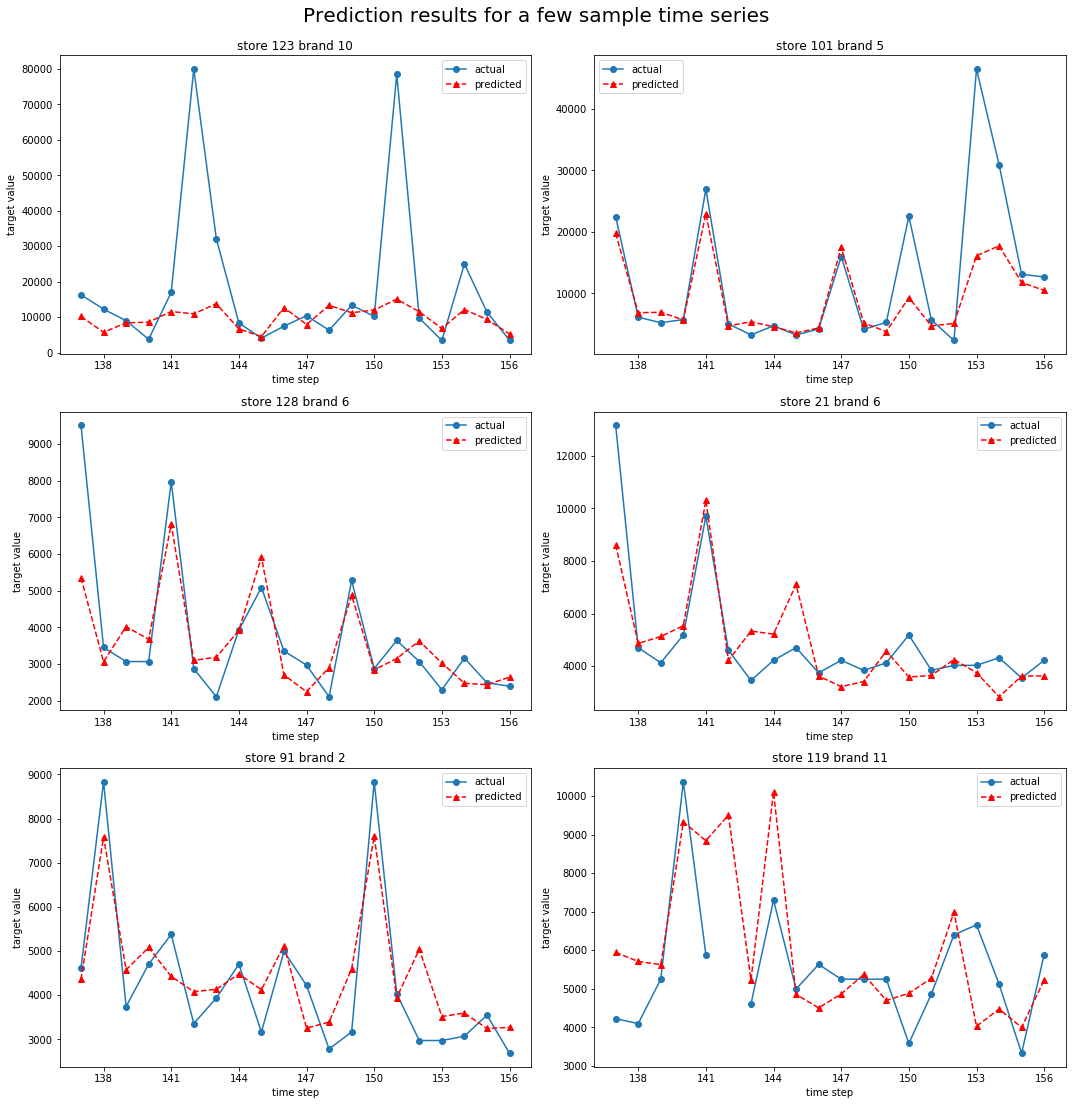

In [8]:
results = combined[["week", "store", "brand", "prediction"]]
results.rename(columns={"prediction": "move"}, inplace=True)
actual = combined[["week", "store", "brand", "actual"]]
actual.rename(columns={"actual": "move"}, inplace=True)
store_list = combined["store"].unique()
brand_list = combined["brand"].unique()

plot_predictions_with_history(
    results,
    actual,
    store_list,
    brand_list,
    "week",
    "move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=137,
    num_samples=6,
    predict_at_timestep=135,
    line_at_predict_time=False,
    title="Prediction results for a few sample time series",
    x_label="time step",
    y_label="target value",
    random_seed=6,
)

## Additional Reading

\[1\] Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. 2017. LightGBM: A highly efficient gradient boosting decision tree. In Advances in Neural Information Processing Systems. 3146–3154.<br>
\[2\] Alexey Natekin and Alois Knoll. 2013. Gradient boosting machines, a tutorial. Frontiers in neurorobotics, 7 (21). <br>
\[3\] The parameters of LightGBM: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst <br>
\[4\] Anna Veronika Dorogush, Vasily Ershov, and Andrey Gulin. 2018. CatBoost: gradient boosting with categorical features support. arXiv preprint arXiv:1810.11363 (2018).<br>

